In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import os 
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torchvision.transforms.functional import to_pil_image
import cv2
import pandas as pd

In [2]:
train_transformer = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

val_test_transformer = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
data_folder = 'downloaded_data'
train_path = os.path.join(data_folder, "train")
val_path = os.path.join(data_folder, "test")
test_path = os.path.join(data_folder, "val")
batch_size = 4

train_ds = torchvision.datasets.ImageFolder(train_path, train_transformer)
val_ds = torchvision.datasets.ImageFolder(val_path, val_test_transformer)
test_ds = torchvision.datasets.ImageFolder(test_path, val_test_transformer)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

class_names = train_ds.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['benign', 'malignant']


1977
0


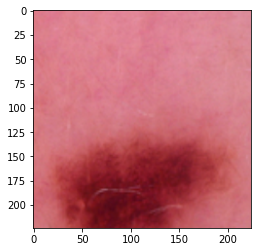

In [4]:
def denormalize(x_, mean, std):
    x = x_.clone()
    for i in range(3):
        x[i] = x[i]*std[i]+mean[i]
    x = to_pil_image(x)        
    return x

img, label = train_ds[0]
img = denormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
print(len(train_ds))
print(label)
plt.imshow(img)

In [5]:
def get_model(outputs=2):
    model = torchvision.models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, outputs)
    return model

In [6]:
def train_model(model, train_dl, val_dl, criterion, optimizer, scheduler, num_epochs=25):
    def process(dl, train):
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(train):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if train:
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        return running_loss, running_corrects

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        running_loss, running_corrects = process(train_dl, True)
        scheduler.step()
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects / len(train_dl.dataset)
        print(f"Training Phase --- Loss: {epoch_loss:.4f} Acc: {(epoch_acc * 100):.4f}")
        
        model.eval()
        with torch.no_grad():
            running_loss, running_corrects = process(val_dl, False)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects / len(val_dl.dataset)
        print(f"Validation Phase --- Loss: {epoch_loss:.4f} Acc: {(epoch_acc * 100):.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [11]:
def test(model, loss_func, dl):
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_func(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / dataset_sizes["test"]
    epoch_acc = running_corrects.double().item() / dataset_sizes["test"]
    print(f"Testing Phase --- Loss: {epoch_loss:.4f} Acc: {(epoch_acc * 100):.4f}")
    return epoch_loss, epoch_acc

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model()
model = model.to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model, train_dl, val_dl, loss_func, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
Training Phase --- Loss: 0.6861 Acc: 70.8144
Validation Phase --- Loss: 0.3709 Acc: 82.8788

Epoch 1/24
----------
Training Phase --- Loss: 0.6302 Acc: 73.1917
Validation Phase --- Loss: 0.4113 Acc: 81.6667

Epoch 2/24
----------
Training Phase --- Loss: 0.5691 Acc: 75.5690
Validation Phase --- Loss: 0.3761 Acc: 82.8788

Epoch 3/24
----------
Training Phase --- Loss: 0.5732 Acc: 74.2539
Validation Phase --- Loss: 0.3346 Acc: 85.7576

Epoch 4/24
----------
Training Phase --- Loss: 0.5718 Acc: 74.8103
Validation Phase --- Loss: 0.3298 Acc: 84.6970

Epoch 5/24
----------
Training Phase --- Loss: 0.5244 Acc: 77.0865
Validation Phase --- Loss: 0.4298 Acc: 78.3333

Epoch 6/24
----------
Training Phase --- Loss: 0.4609 Acc: 80.1214
Validation Phase --- Loss: 0.3308 Acc: 84.8485

Epoch 7/24
----------
Training Phase --- Loss: 0.3985 Acc: 80.4755
Validation Phase --- Loss: 0.3131 Acc: 85.4545

Epoch 8/24
----------
Training Phase --- Loss: 0.3798 Acc: 82.1447
Validation Ph

In [14]:
test(model, loss_func, test_dl)

Testing Phase --- Loss: 0.2028 Acc: 92.8788


(0.20284715810169776, 0.9287878787878788)

In [ ]:
torch.save(model.state_dict(), "final.pth")

In [13]:
testing_model = get_model()
testing_model = testing_model.to(device)

weights = torch.load("final.pth")
testing_model.load_state_dict(weights)

loss_func = nn.CrossEntropyLoss()

test(testing_model, loss_func, test_dl)

Testing Phase --- Loss: 0.2028 Acc: 92.8788


(0.20284715810169776, 0.9287878787878788)